In [1]:
import os
import scipy.io as sio
# 切换到包含文件的目录
os.chdir('/Users/gengxingri/Desktop/Leetcodes/HUAWEI')

from decimal import Decimal
import numpy as np

from scipy.sparse import csc_matrix,  identity
from scipy.sparse.linalg import eigsh, norm, spsolve, cg, minres
import scipy.sparse as sp
import scipy.sparse.linalg as sla

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import time


In [2]:
# 读取.mat 文件
data = sio.loadmat('olafu.mat')


A = data['Problem']['A'][0][0]
print(A.shape, type(A))

b = data['Problem']['b'][0][0]
print(b.shape, type(b))



(16146, 16146) <class 'scipy.sparse._csc.csc_matrix'>
(16146, 1) <class 'numpy.ndarray'>


In [3]:
# Calculate the condition number
start_time = time.time()

# return eigenvalues that have the min and max abs values, respectively
eigval_max = eigsh(A, k=1, which='LM', return_eigenvectors=False)[0]
eigval_min = eigsh(A, k=1, which='SM', return_eigenvectors=False, tol=5)[0] # the result is vary rough
print(eigval_min, eigval_max)

condition_number = eigval_max / eigval_min

print("Condition number based on eigenvalues:", condition_number)

end_time = time.time()
execution_time = end_time - start_time

print(f"Runing time：{execution_time} s")

3788110.9542573662 947870338881.5409
Condition number based on eigenvalues: 250222.43285040327
Runing time：0.20304274559020996 s


In [4]:
# Create the diagonal preconditioner
n = A.shape[0]
diag_A = A.diagonal()

D = csc_matrix((1 / np.sqrt(diag_A), (np.arange(n), np.arange(n))), shape=(n, n))

# Apply preconditioning
A_new = D.dot(A.dot(D))

# 将 numpy 数组转换为 CSC 格式的稀疏矩阵
b_sparse = csc_matrix(b)

b_new = D.dot(b_sparse) / norm(D.dot(b_sparse)) 

print(A_new.diagonal(), norm(b_new))

[1. 1. 1. ... 1. 1. 1.] 1.0


In [5]:
# Calculate the condition number

eigval_max = eigsh(A_new, k=1, which='LM', return_eigenvectors=False)[0]
eigval_min = eigsh(A_new, k=1, which='SM', return_eigenvectors=False, tol=5)[0]
print(eigval_min, eigval_max)

preconditioned_cond = eigval_max / eigval_min

print("Condition number based on eigenvalues:", preconditioned_cond)


0.010207417950479808 15.192884285425976
Condition number based on eigenvalues: 1488.4160087431144


In [6]:
# Unique solution of Ax = b

x_unique = spsolve(A_new, b_new)
print(x_unique)

[ -0.34351415  -2.74329069  -7.30720538 ... -51.250221    -7.71784307
  55.87781126]


In [7]:
# CG mtheod
def conjugate_gradient_sparse(A, b, tol=1e-8, max_iter=5*b.shape[0]):
    n = b.shape[0] 
    x = np.zeros(n).reshape((n,1))
    r = b - A @ x
    #print(r.shape, type(r))
    xk_cg =[]
    
    
    p = r.copy()
    r_norm_sq = np.dot(r.T,r)
    errors = []  # Initial error
    #print(x.shape, r_norm_sq.shape)

    for i in range(max_iter):
        Ap = A @ p
        alpha = r_norm_sq / np.dot(p.T, Ap)
        x = x + alpha * p
        r -= alpha * Ap
        
        r_norm_sq_new = np.dot(r.T, r)
        
        #print(r_norm_sq_new.shape)
        errors.append(np.sqrt(r_norm_sq_new))  # Append new error
        xk_cg.append(x)
        if np.sqrt(r_norm_sq_new) < tol:
            print(f"Converged after {i+1} iterations")
            return x, errors, xk_cg
        
        beta = r_norm_sq_new / r_norm_sq
        p = r + beta * p
        r_norm_sq = r_norm_sq_new
    
    print(f"Did not converge after {max_iter} iterations")
    return x, errors, xk_cg

# Solve using our CG implementation
start_time = time.time()

b_array = b_new.toarray()
x_cg, errors, xk = conjugate_gradient_sparse(A_new, b_array, tol=1e-12)

cg_time = time.time() - start_time

print(f"CG method took {cg_time:.4f} seconds")

# change the type of errors_cg and xk_cg
errors_cg = [arr[0][0] for arr in errors]
xk_cg = [np.reshape(arr,-1) for arr in xk]

Converged after 34270 iterations
CG method took 91.8644 seconds


In [8]:

# MINRES method

errors_minres = []

xk_minres = []

def callback(xk):
    rk = b_array - A_new.dot(xk).reshape(-1,1)
    error_norm = np.linalg.norm(rk)
    errors_minres.append(error_norm)
    xk_minres.append(xk)
    return np.linalg.norm(rk)

x_minres, info_minres = minres(A_new, b_array, tol=0, maxiter=5*b.shape[0], callback=callback)
print(x_minres, info_minres)
print('\n', len(errors_minres), errors_minres[0:5])


[ -0.34351393  -2.74328905  -7.30720102 ... -51.25019963  -7.71783811
  55.87778732] 0

 25874 [0.6948041950255897, 0.646272371461057, 0.5434742662452567, 0.4278102433591355, 0.3871607015285532]


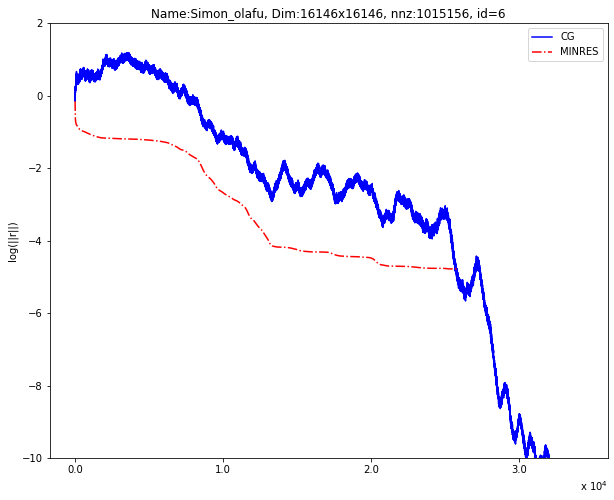

In [9]:
# Plot the log(||r||) errors

def plot_norm_4(cg_errors, minres_errors):
    # Create the plot
    fig, ax = plt.subplots(figsize=(10,8))
    ax.plot(range(1, len(cg_errors)+1), cg_errors, 'b-', label='CG')
    ax.plot(range(1, len(minres_errors)+1), minres_errors, 'r-.', label='MINRES')

    # Set labels and title
    ax.set_xlabel('iteration count')
    ax.set_xlabel('x $10^4$', loc='right')
    ax.set_ylabel('log(||r||)')
    ax.set_title('Name:Simon_olafu, Dim:16146x16146, nnz:1015156, id=6')

    # Set y-axis limits
    ax.set_xticks(np.arange(0, 30001, 10000))
    ax.set_xticklabels([f'{i/10000}' for i in np.arange(0, 30001, 10000)])
    ax.set_ylim(-10, 2)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(2))

    # Add legend
    ax.legend()


    # Show the plot
    plt.show()

    
# errors of log||r|| in each iteration

# errors of cg
cg_errors_norm4 = np.log10(errors_cg)



# errors of minres
minres_errors_norm4 = np.log10(errors_minres)



# plot
plot_norm_4(cg_errors_norm4, minres_errors_norm4)

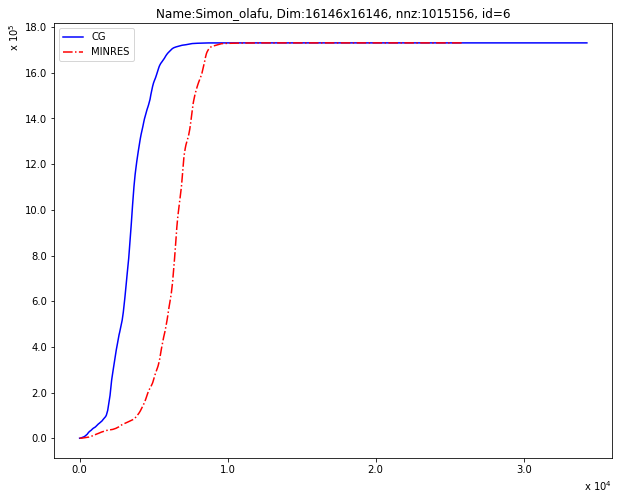

In [10]:
# Plot the ||x||

def plot_norm_5(cg_errors, minres_errors):
    # Create the plot
    fig, ax = plt.subplots(figsize=(10,8))
    ax.plot(range(1,len(cg_errors)+1), cg_errors, 'b-', label='CG')
    ax.plot(range(1,len(minres_errors)+1), minres_errors, 'r-.', label='MINRES')

    # Set labels and title
    ax.set_xlabel('iteration count')
    ax.set_xlabel('x $10^4$', loc='right')
    
    ax.set_ylabel('||x||')
    ax.set_ylabel('x $10^5$', loc='top')
    ax.set_title('Name:Simon_olafu, Dim:16146x16146, nnz:1015156, id=6')

    # Set y-axis limits
    ax.set_xticks(np.arange(0, 30001, 10000))
    ax.set_xticklabels([f'{i/10000}' for i in np.arange(0, 30001, 10000)])
    
    ax.set_yticks(np.arange(0, 1800001, 200000))
    ax.set_yticklabels([f'{i/100000}' for i in np.arange(0, 1800001, 200000)])
    
    #ax.yaxis.set_major_locator(ticker.MultipleLocator(2))

    # Add legend
    ax.legend()


    # Show the plot
    plt.show()
    
    
    
xk_cg_norm5 =  np.array([np.linalg.norm(xk) for xk in xk_cg])
xk_minres_norm5 =  np.array([np.linalg.norm(xk) for xk in xk_minres])

# plot
plot_norm_5(xk_cg_norm5, xk_minres_norm5)

In [11]:
# Now plot the indefinitesystem (A-\delta I)x = b, where\delta = 0.5

I = identity(n, format='csc')
A_indef = A_new - 0.5*I

# MINRES method

errors_minres_indef = []

xk_minres_indef = []

def callback(xk):
    rk = b_array - A_indef.dot(xk).reshape(-1,1)
    error_norm = np.linalg.norm(rk)
    errors_minres_indef.append(error_norm)
    xk_minres_indef.append(xk)
    return np.linalg.norm(rk)

x_indef_minres, info_indef_minres = minres(A_indef, b_array, tol=1e-11, callback=callback)
print(x_indef_minres, info_indef_minres)

[ 0.01012205 -0.00288163 -0.00202698 ... -0.01595044  0.00415821
 -0.01396475] 0


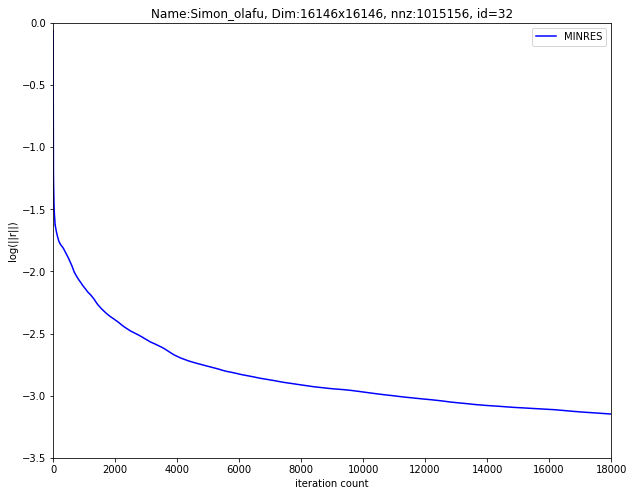

In [12]:
# Plot the log(||r||) errors

def plot_indef_log(minres_errors):
    # Create the plot
    fig, ax = plt.subplots(figsize=(10,8))
    
    ax.plot(range(1,len(minres_errors)+1), minres_errors, 'b-', label='MINRES')

    # Set labels and title
    ax.set_xlabel('iteration count')
    ax.set_ylabel('log(||r||)')
    ax.set_title('Name:Simon_olafu, Dim:16146x16146, nnz:1015156, id=32')

    # Set y-axis limits
    ax.set_xlim(0, 18000)
    ax.set_ylim(-3.5, 0)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))

    # Add legend
    ax.legend()


    # Show the plot
    plt.show()
    
    
    
errors_indef_minres =  np.array([np.linalg.norm(err) for err in errors_minres_indef])

minres_errors_indef = np.log10(errors_indef_minres)

# plot
plot_indef_log(minres_errors_indef)

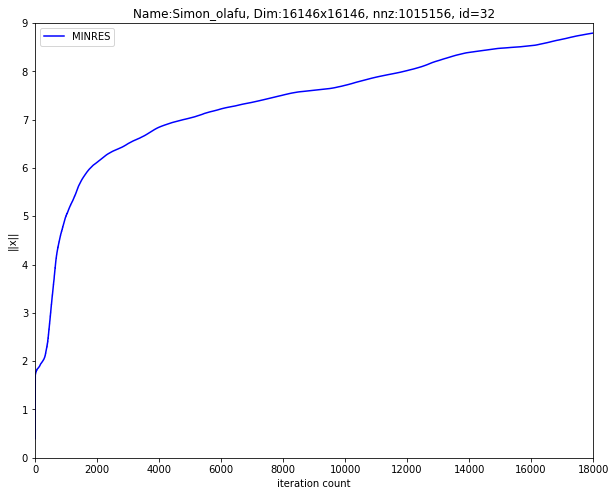

In [13]:
# Plot the ||x|| for the indefinite system

def plot_indef_norm(minres_errors):
    # Create the plot
    fig, ax = plt.subplots(figsize=(10,8))
    
    ax.plot(range(1,len(minres_errors)+1), minres_errors, 'b-', label='MINRES')

    # Set labels and title
    ax.set_xlabel('iteration count')
    ax.set_ylabel('||x||')
    ax.set_title('Name:Simon_olafu, Dim:16146x16146, nnz:1015156, id=32')

    # Set y-axis limits
    ax.set_xlim(0, 18000)
    ax.set_ylim(0, 9)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # Add legend
    ax.legend()


    # Show the plot
    plt.show()
    
    

xk_minres_indef_norm =  np.array([np.linalg.norm(xk) for xk in xk_minres_indef])

# plot
plot_indef_norm(xk_minres_indef_norm)